In [1]:
import sys
import os

functionPath = os.path.join( '../../', 'text_mining' )
sys.path.append( functionPath )

import get_vectors as gv

In [2]:
import numpy as np
import pandas as pd 
from sklearn.svm import SVC
from sklearn import metrics 

LABEL_CNT = 3 

In [102]:
SVD_vec = gv.get_SVD_vectors( '../../text_mining/', '../../src_txt/', 100 )

In [3]:
LDA_vec = gv.get_LDA_vectors( '../../text_mining/', '../../src_txt/', 100 )
TFIDF_vec, _ = gv.get_tf_idf( '../../text_mining/', '../../src_txt/' )
TFIDF_vec = TFIDF_vec.toarray()

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\h5110\AppData\Local\Temp\jieba.cache
Loading model cost 0.997 seconds.
Prefix dict has been built successfully.


In [122]:
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import Doc2Vec
tokenized_docs = gv.get_tokenized_docs('../../text_mining/', '../../src_txt/')
x_train = []
for i, doc in enumerate(tokenized_docs):
    x_train.append(gensim.models.doc2vec.TaggedDocument(doc, tags=[i]))

model = Doc2Vec(x_train, window=2, vector_size=100)
doc_vectors = []
for doc in x_train:
    doc_vectors.append(model.docvecs[doc.tags[0]])

<ipython-input-122-67aacd5d6556>:12: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  doc_vectors.append(model.docvecs[doc.tags[0]])


In [4]:
df = pd.read_csv( '../../text_mining/semi_super_label.csv')
train_index = sorted( list( set( df['file'] ) ) )

In [188]:
Y = []
for i in range( len( train_index ) ):
    Y.append( [ False ] * LABEL_CNT )
    labels = df[ 'labels' ][ i ].rstrip()[1:-1].split(' ')
    if labels[0] != '' :
        for label in labels : 
            l = int( label ) - 1 
            Y[-1][l] = True  
    Y[-1] = np.array( Y[-1] )
Y = np.array( Y )

In [189]:
X = [SVD_vec[i] for i in train_index]

In [38]:
from sklearn.model_selection import train_test_split

In [220]:
train_xs = []
test_xs = []
train_ys = []
test_ys = []

for i in range( 3 ) : 
    train_x, test_x, train_y, test_y = train_test_split( X, Y[:,i], test_size=0.1)
    train_xs.append(train_x)
    test_xs.append(test_x)
    train_ys.append(train_y)
    test_ys.append(test_y)
# train_x0, test_x0, train_y0, test_y0 = train_test_split( X, Y[:,0], test_size=0.1)
# train_x1, test_x1, train_y1, test_y1 = train_test_split( X, Y[:,1], test_size=0.1)
# train_x2, test_x2, train_y2, test_y2 = train_test_split( X, Y[:,2], test_size=0.1)

In [221]:
SVM_model0 = SVC( kernel='rbf', C=10, gamma=0.1, probability=True )
SVM_model1 = SVC( kernel='rbf', C=1, gamma=1, probability=True )
SVM_model2 = SVC( kernel='linear', C=1, probability=True )

In [222]:
SVM_model0.fit(train_xs[0], train_ys[0])
predicted0 = SVM_model0.predict(test_xs[0])
print(metrics.classification_report(test_ys[0], predicted0))

              precision    recall  f1-score   support

       False       0.91      0.90      0.91        70
        True       0.77      0.80      0.79        30

    accuracy                           0.87       100
   macro avg       0.84      0.85      0.85       100
weighted avg       0.87      0.87      0.87       100



In [223]:
SVM_model1.fit(train_xs[1], train_ys[1])
predicted1 = SVM_model1.predict(test_xs[1])
print(metrics.classification_report(test_ys[1], predicted1))

              precision    recall  f1-score   support

       False       0.84      0.96      0.90        50
        True       0.95      0.82      0.88        50

    accuracy                           0.89       100
   macro avg       0.90      0.89      0.89       100
weighted avg       0.90      0.89      0.89       100



In [224]:
SVM_model2.fit(train_xs[2], train_ys[2])
predicted2 = SVM_model2.predict(test_xs[2])
print(metrics.classification_report(test_ys[2], predicted2))

              precision    recall  f1-score   support

       False       0.89      0.97      0.93        76
        True       0.88      0.62      0.73        24

    accuracy                           0.89       100
   macro avg       0.89      0.80      0.83       100
weighted avg       0.89      0.89      0.88       100



In [225]:
SVM_model = [SVM_model0, SVM_model1, SVM_model2]

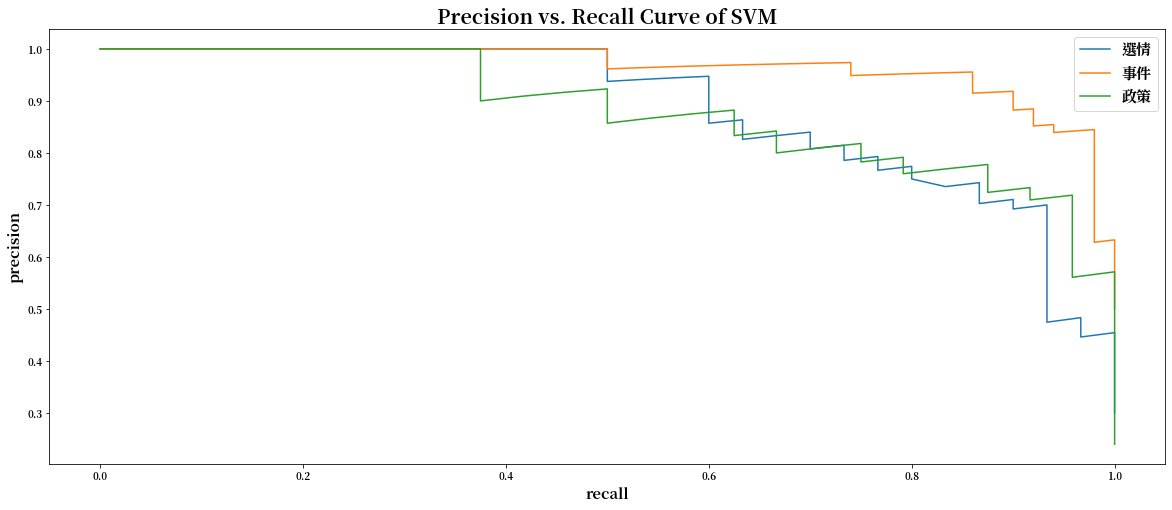

In [229]:
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot as plt
plt.rcParams['font.sans-serif'] = ['Noto Serif TC']
plt.figure( figsize=( 20, 8 ) )

labels = ["選情", "事件", "政策"]
for i in range( 3 ) :
    y_prob = SVM_model[i].predict_proba( test_xs[i] )[:,1]
    y_true = test_ys[i]
    precision, recall, _ = precision_recall_curve( y_true, y_prob )
    plt.plot( recall, precision, label=labels[i] )

plt.legend( loc='best', prop={'size': 15} )
plt.xlabel( "recall", size=15 )
plt.ylabel( "precision", size=15 )
plt.title( "Precision vs. Recall Curve of SVM", size=20 )
plt.savefig( './pr_curve.jpg', bbox_inches="tight" )
plt.show()

In [24]:
from sklearn.model_selection import cross_val_score

score = cross_val_score( SVM_model, X, Y[:,2], cv=10, scoring='f1_macro' )
print( score.mean() )

0.7677480539361337


In [197]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1, 0.1, 0.01, 1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
scores = ['precision', 'recall']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

     # 呼叫 GridSearchCV，將 SVC(), tuned_parameters, cv=5, 還有 scoring 傳遞進去，
    clf = GridSearchCV(SVC(), tuned_parameters, cv=10,
                       scoring='%s_macro' % score)
    # 用訓練集訓練這個學習器 clf
    clf.fit(train_xs[2], train_ys[2])

    print("Best parameters set found on development set:")
    print()

    # 再呼叫 clf.best_params_ 就能直接得到最好的引數搭配結果
    print(clf.best_params_)

    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']

    # 看一下具體的引數間不同數值的組合後得到的分數是多少
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

    print()


# Tuning hyper-parameters for precision



d:\New folder\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\New folder\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\New folder\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\New folder\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and b

Best parameters set found on development set:

{'C': 1, 'kernel': 'linear'}

Grid scores on development set:

0.903 (+/-0.086) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.551 (+/-0.463) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.399 (+/-0.004) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.399 (+/-0.004) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.399 (+/-0.004) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.906 (+/-0.097) for {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.899 (+/-0.084) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.551 (+/-0.463) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.399 (+/-0.004) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.399 (+/-0.004) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.859 (+/-0.092) for {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
0.893 (+/-0.104) for {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
0.900 (+/-0.080) for {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
0.551 (+/-0.463) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.399 (+/-0.00

In [7]:
SVM_model_1 = SVC( kernel='poly', degree=2, coef0=1, C=1 )
SVM_model_2 = SVC( kernel='poly', degree=2, coef0=1, C=1 )
SVM_model_3 = SVC( kernel='poly', degree=2, coef0=1, C=1 )

In [29]:
SVM_model_1.fit( X, Y[ :, 0 ] )
SVM_model_2.fit( X, Y[ :, 1 ] )
SVM_model_3.fit( X, Y[ :, 2 ] )

SVC(C=1, coef0=1, degree=2, kernel='poly')

In [30]:
predict_y = []
predict_y.append( SVM_model_1.predict( X ) )
predict_y.append( SVM_model_2.predict( X ) )
predict_y.append( SVM_model_3.predict( X ) )

In [38]:
for i in range( 3 ):
    result = predict_y[ i ]
    with open( f'../../tm_web/backend/data/type{i+1}.csv', 'w' ) as f:
        f.write( f'{i}' )
        for i in range( len( result ) ):
            if result[ i ] == True:
                f.write( f'\n{i}.txt' )